In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

In [2]:
import pandas as pd

# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


,Month,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
0,2012-01-01,1131852,571940,257116,140013,357516,344274,51043,329883,624695,...,800628,650236,1127393,783952,1513332,335710,916965,314654,35418,1260510
1,2012-02-01,857289,585556,187917,89805,505896,424953,80220,239242,899144,...,795356,680567,188827,868576,1277664,197072,318522,516140,36604,2136484
2,2012-03-01,1438501,834142,679281,103577,583887,352675,102980,394945,1093638,...,873858,1318538,856382,627236,2343448,132200,605914,410308,43197,3264810
3,2012-04-01,986602,866221,523202,203456,515903,403517,52773,260953,874217,...,1004028,919493,460815,829432,1861188,128164,472522,290407,45396,2631466
4,2012-05-01,991668,1061702,611369,80327,767522,627232,78115,680323,994697,...,2098300,632778,239200,934532,2215922,202210,337894,284868,41469,2945175


In [4]:
French_Wine_Export_in_Euros_DF.describe()

,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,ALSACE_BLANC_OTHER,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
count,5.000000e+01,5.000000e+01,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,...,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,1.189956e+06,8.037735e+05,428923.380000,119348.360000,6.173951e+05,414037.100000,88636.820000,361437.900000,8.035454e+05,38337.801569,...,1.607702e+06,8.523710e+05,7.498312e+05,1.072562e+06,2.876061e+06,235678.640000,5.760031e+05,4.986103e+05,52907.080000,2.912355e+06
std,2.780384e+05,1.691507e+05,158179.648178,65116.609016,2.765474e+05,116398.158498,68347.582681,110140.042643,2.732401e+05,6088.988573,...,7.064099e+05,2.458533e+05,3.592653e+05,4.307817e+05,1.366642e+06,140071.773582,2.398091e+05,1.720202e+05,9667.885799,6.675896e+05
min,5.477480e+05,3.514620e+05,88329.000000,19546.000000,3.131500e+05,168388.000000,31864.000000,192553.000000,3.085880e+05,18550.156250,...,7.935600e+05,3.992940e+05,1.888270e+05,5.558550e+05,1.277664e+06,77550.000000,2.053840e+05,2.311020e+05,35238.000000,1.260510e+06
25%,1.004816e+06,6.791068e+05,316753.500000,82278.500000,4.801042e+05,333264.500000,52845.750000,293690.250000,6.061862e+05,35457.417067,...,1.047350e+06,6.819278e+05,5.089532e+05,7.219495e+05,2.025437e+06,152307.750000,3.751060e+05,3.725818e+05,46721.000000,2.500847e+06
50%,1.161726e+06,8.070940e+05,445554.500000,98656.000000,5.449660e+05,401774.500000,76561.500000,335180.000000,7.884350e+05,38715.394123,...,1.506712e+06,8.120535e+05,7.065070e+05,9.246160e+05,2.519672e+06,203395.000000,5.414685e+05,4.674045e+05,52305.000000,2.896628e+06
75%,1.323582e+06,8.880218e+05,542924.000000,161694.000000,6.549058e+05,515408.000000,102011.750000,417475.000000,8.980862e+05,41900.001008,...,1.936743e+06,1.023269e+06,9.285735e+05,1.207832e+06,3.018630e+06,257873.500000,7.998980e+05,6.143272e+05,59756.250000,3.380802e+06
max,2.166585e+06,1.216720e+06,857207.000000,317661.000000,1.871515e+06,635447.000000,510151.000000,680323.000000,1.458234e+06,52823.280702,...,3.946934e+06,1.334550e+06,1.755449e+06,2.312776e+06,8.652432e+06,879037.000000,1.076535e+06,1.063568e+06,71487.000000,4.664273e+06


To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

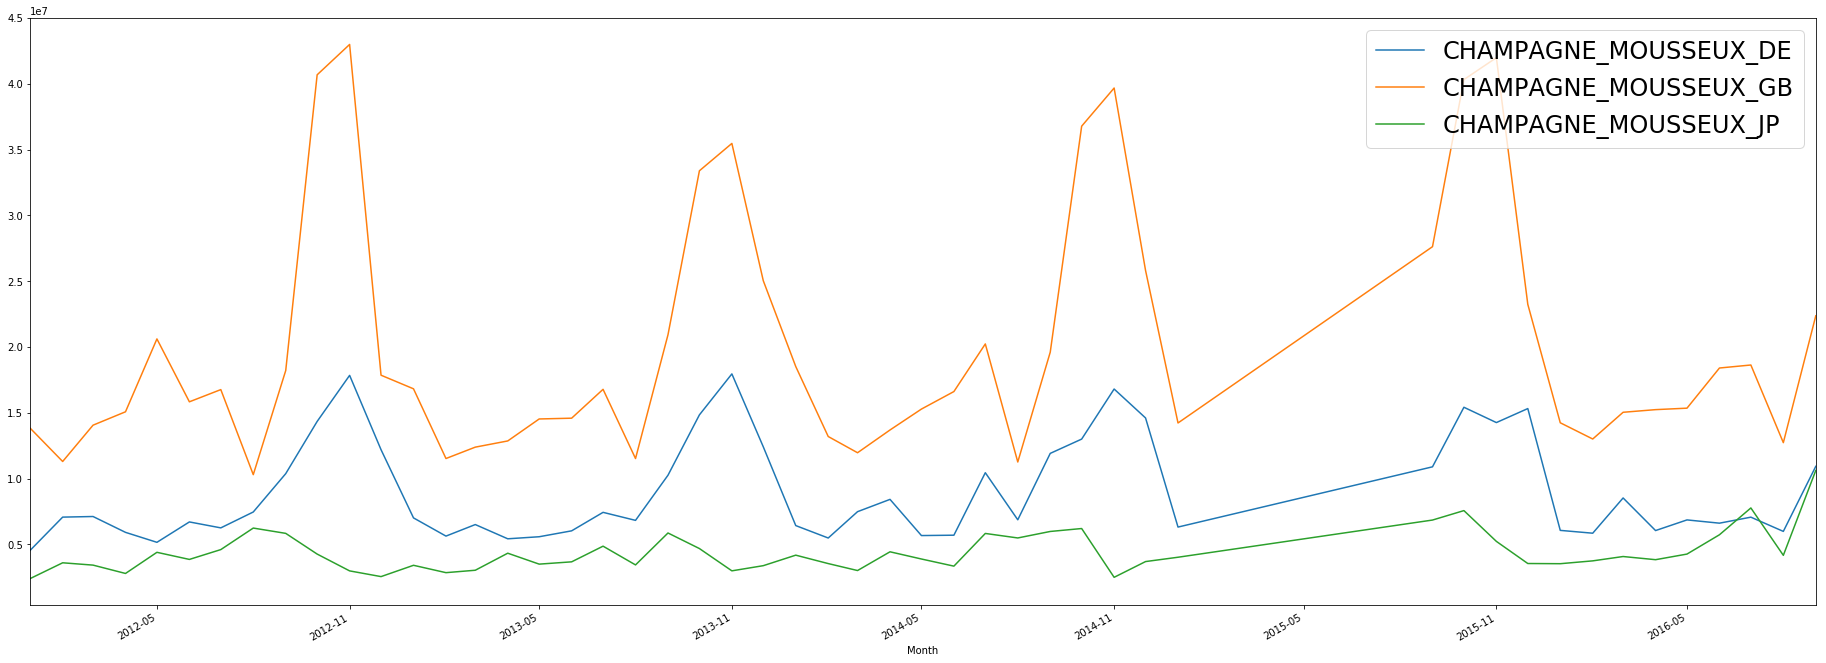

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

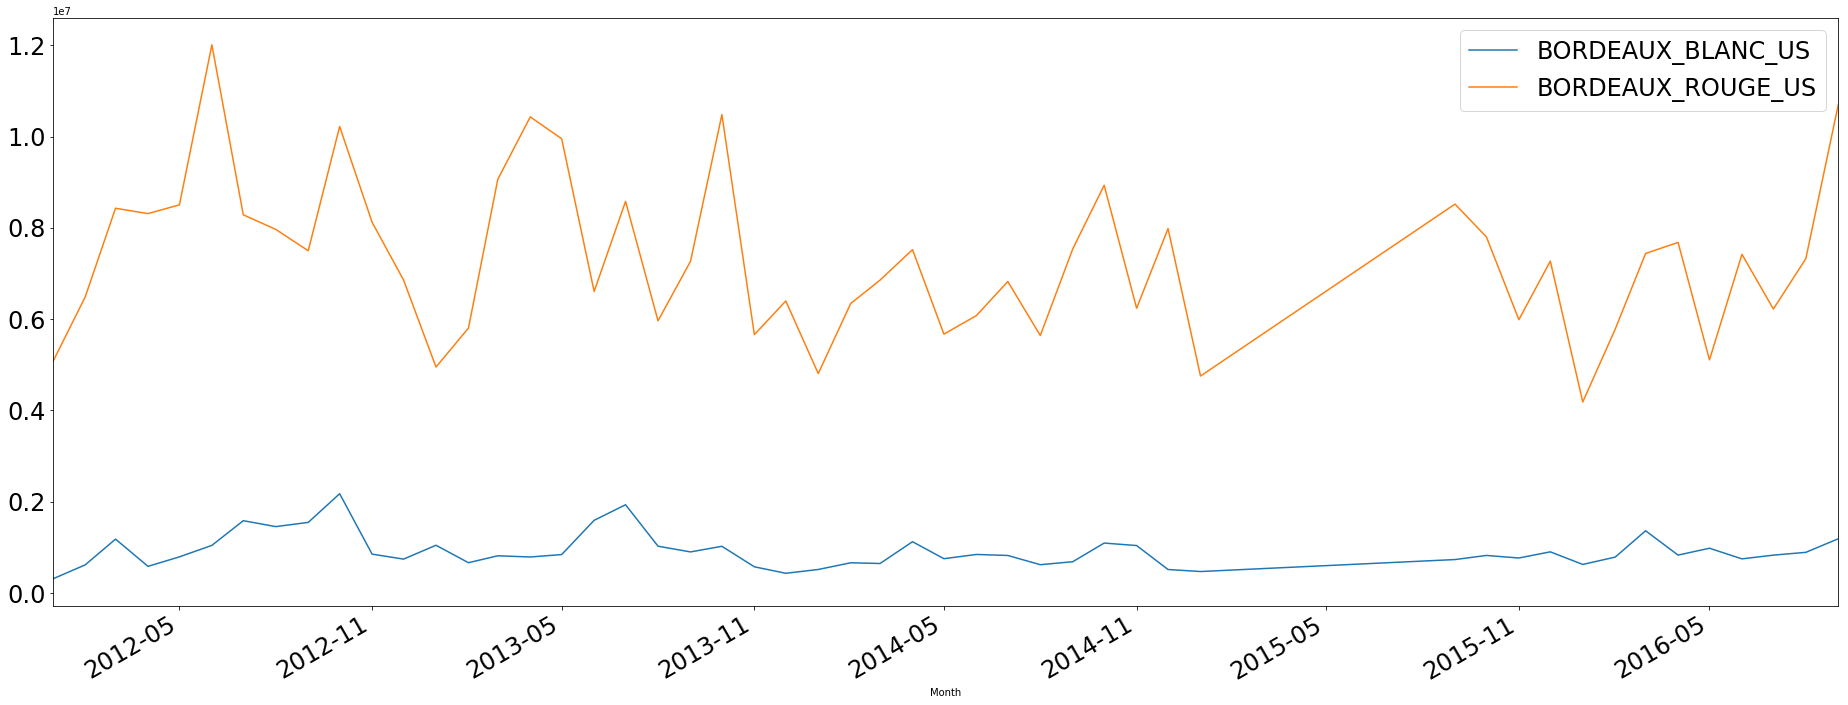

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


,ALSACE_BLANC_CN,BEAUJOLAIS_ROUGE_CN,BORDEAUX_BLANC_CN,BORDEAUX_ROUGE_CN,BOURGOGNE_BLANC_CN,BOURGOGNE_ROUGE_CN,CHAMPAGNE_MOUSSEUX_CN,EUROPE_ROUGE_CN,FRANCE_BLANC_CN,FRANCE_MOUSSEUX_CN,FRANCE_ROUGE_CN,LANGUEDOC_ROUGE_CN,LOIRE_BLANC_CN,LOIRE_ROUGE_CN,OTHER_ROUGE_CN,RHÔNE_ROUGE_CN
count,50.000000,50.00000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01
mean,119348.360000,130292.47000,4.993186e+05,1.138432e+07,242575.340000,7.436432e+05,6.225160e+05,8.313372e+05,12978.062000,93298.256667,11185.281403,1.304245e+06,48771.330000,92016.740000,52969.948000,7.498312e+05
std,65116.609016,102214.45714,2.936971e+05,3.081051e+06,99492.736867,4.176045e+05,3.812781e+05,2.337996e+05,24705.479992,63521.773261,13888.069451,6.352887e+05,27922.200988,54704.609614,36129.014739,3.592653e+05
min,19546.000000,5833.00000,1.678740e+05,5.377235e+06,75396.000000,2.725460e+05,1.976760e+05,3.270090e+05,0.000000,20488.500000,260.500000,4.916860e+05,16643.500000,15325.000000,6337.750000,1.888270e+05
25%,82278.500000,66206.50000,3.117738e+05,9.737536e+06,171633.250000,4.214805e+05,3.897600e+05,6.529608e+05,1607.250000,46355.750000,4759.017857,9.207640e+05,31191.250000,54588.250000,28779.650000,5.089532e+05
50%,98656.000000,98427.50000,4.148980e+05,1.039686e+07,237099.500000,6.060540e+05,5.299100e+05,8.078685e+05,6237.750000,82644.583333,8837.333333,1.211934e+06,37845.750000,77491.500000,44118.875000,7.065070e+05
75%,161694.000000,158673.75000,5.623658e+05,1.316721e+07,308119.750000,9.648268e+05,7.029695e+05,9.859902e+05,14842.000000,118693.250000,12869.584821,1.416010e+06,62140.375000,119915.500000,62176.000000,9.285735e+05
max,317661.000000,453985.00000,1.890312e+06,1.905088e+07,535157.000000,2.021852e+06,2.103130e+06,1.367882e+06,163701.000000,366064.500000,96564.222222,3.607517e+06,151128.000000,272948.000000,179114.750000,1.755449e+06


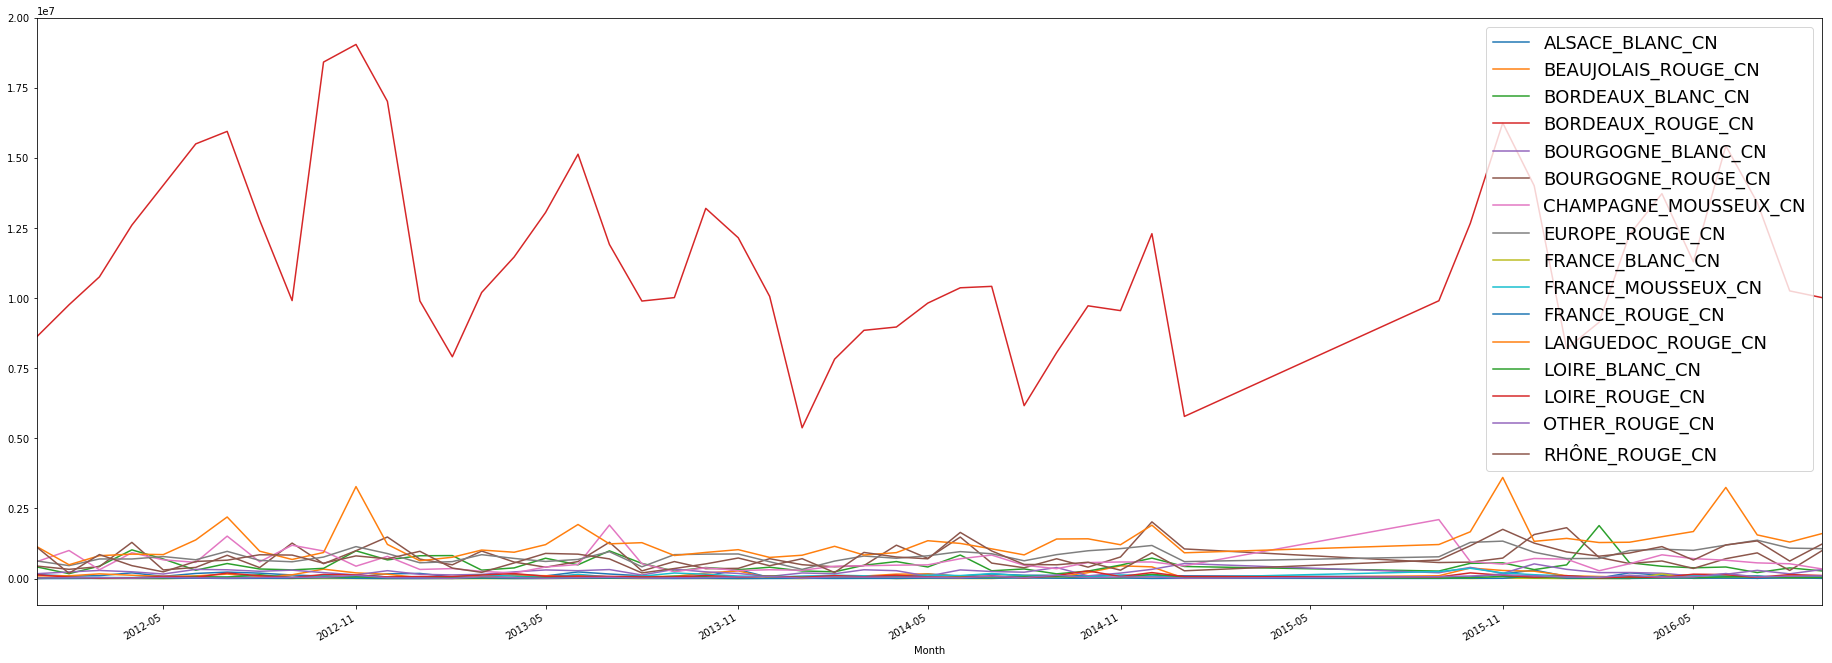

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


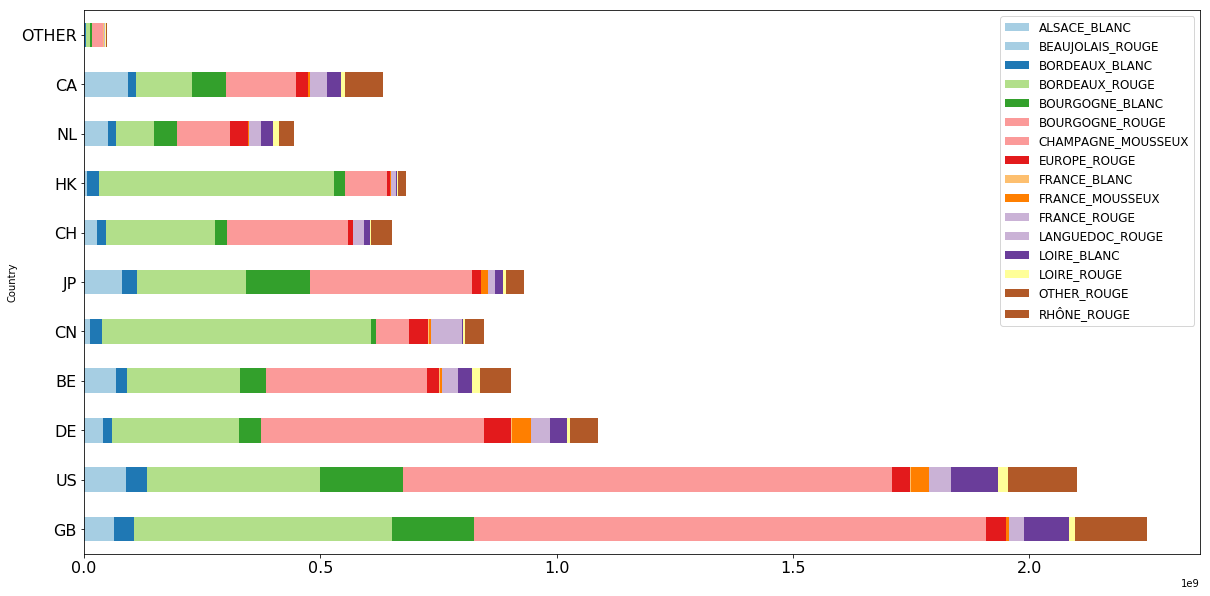

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Grouping Definition


Here, we start by defining as hierarchical model to forecast wine export by forecasting country and wine type and variant exports.

A wine type export is computed by aggregating (grouping) all variants exported to all countries.

In this section, we describe the definition of the grouping.
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Grouping definition
lGroups = {}
lGroups["Country"] = Countries
lGroups["Variant"] = Variants
lGroups["Wine"] = Wines

lHierarchy = {};
lHierarchy['Levels'] = None;
lHierarchy['Data'] = None;
lHierarchy['Groups']= lGroups;
# the most important !!!!
lHierarchy['GroupOrder']= ["Wine", "Variant", "Country"]; # group by Wine first, then by variant, etc
lHierarchy['Type'] = "Grouped";
    


We want here to group first by Wine, then by variant and by country. The hierarchy is automatically created based on available columns. 

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Data': None,
 'GroupOrder': ['Wine', 'Variant', 'Country'],
 'Groups': {'Country': ['GB', 'US', 'DE', 'BE', 'CN'],
  'Variant': ['BLANC', 'ROUGE'],
  'Wine': ['ALSACE', 'BEAUJOLAIS', 'BORDEAUX']},
 'Levels': None,
 'Type': 'Grouped'}


Column names are of the type "w_v_c" where w is the wine type, v is the variant and c is the country (in the group order). A different group order leads to a differnet hierarchy and differnet models. The group order has a significant business semantics. 

When aggregated , a group name is emptied :
   * **"_BLANC_BE"** is the aggreagtion of all wine types of variant 'BLANC' that are exported to the country 'BE' and
   * **"__CN"** is the aggreagtion of all wine types of all variants that are exported to the country 'CN' (all what China can drink !!!)
   
All these generated names are not always available in our original training dataset (or even in nature, some wine types and variants are not compatible ;). 

The user may also need to adapt the training dataset column names to match the names defined by the automatic grouping (The name 'BORDEAUX_BLANC_DE' reflects a specific group order).

We plot the hierarchy ...


INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


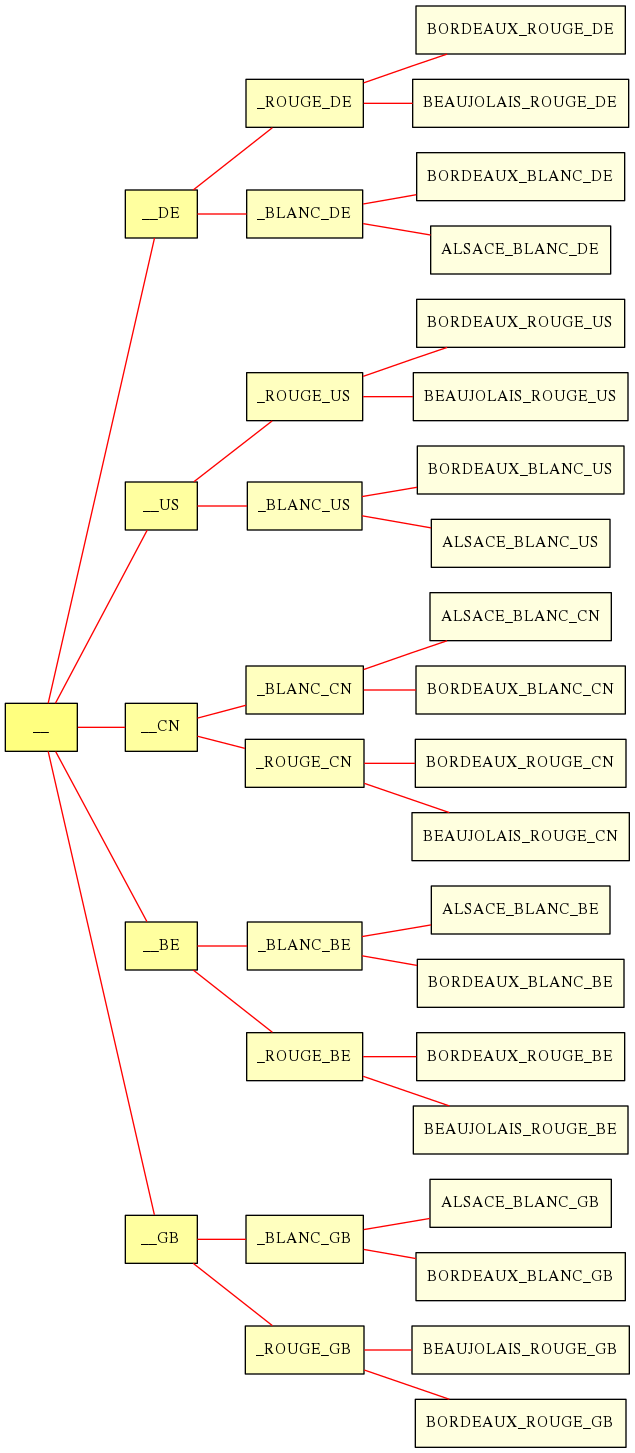

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.19151854515075684


In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'_BLANC_BE': {'ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'},
  '_BLANC_CN': {'ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'},
  '_BLANC_DE': {'ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'},
  '_BLANC_GB': {'ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'},
  '_BLANC_US': {'ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'},
  '_ROUGE_BE': {'BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'},
  '_ROUGE_CN': {'BEAUJOLAIS_ROUGE_CN', 'BORDEAU

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

INFO:pyaf.std:START_HIERARCHICAL_TRAINING
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 ALSACE_BLANC_BE
INFO:pyaf.std:START_TRAINING 'ALSACE_BLANC_BE'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'ALSACE_BLANC_BE' 1.8664367198944092
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_ALSACE_BLANC_BE' Min=547748 Max=2166585  Mean=1210707.78261 StdDev=275212.588648
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle_residue_NoAR' [ConstantTrend + NoCycle + NoAR]
INFO:pyaf.std:TREND_DETAIL '_ALSACE_BLANC_BE_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle_residue_NoA

INFO:pyaf.std:AR_MODEL_COEFF 3 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag11 0.210277136082
INFO:pyaf.std:AR_MODEL_COEFF 4 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag1 0.197001480779
INFO:pyaf.std:AR_MODEL_COEFF 5 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag8 -0.161909167071
INFO:pyaf.std:AR_MODEL_COEFF 6 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag5 0.139807425168
INFO:pyaf.std:AR_MODEL_COEFF 7 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag10 -0.12616649198
INFO:pyaf.std:AR_MODEL_COEFF 8 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag4 0.0842678107072
INFO:pyaf.std:AR_MODEL_COEFF 9 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag9 -0.0178912815177
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 BEAUJOLAIS_ROUGE_BE
INFO:pyaf.std:START_TRAINING 'BEAUJOLAIS_ROUGE_BE'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'BEAUJOLAIS_ROUGE_BE' 1.6531624794006

INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_BORDEAUX_BLANC_BE' Min=245742 Max=691209  Mean=456342.217391 StdDev=106016.69675
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_BORDEAUX_BLANC_BE_PolyTrend_residue_zeroCycle_residue_AR(11)' [PolyTrend + NoCycle + AR(11)]
INFO:pyaf.std:TREND_DETAIL '_BORDEAUX_BLANC_BE_PolyTrend' [PolyTrend]
INFO:pyaf.std:CYCLE_DETAIL '_BORDEAUX_BLANC_BE_PolyTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_BORDEAUX_BLANC_BE_PolyTrend_residue_zeroCycle_residue_AR(11)' [AR(11)]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1261 MAPE_Forecast=0.3746 MAPE_Test=0.051
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6007 MASE_Forecast=0.7477 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=72106.387185 L1_Forecast=141431.055911 L1_Test=20413.1912527
INFO:pyaf.std:MODEL_L2 L2_Fit=72106.387185 L2_Forecast=141431.055911 L2_Test=20413.1912527
INFO:pyaf.std:MODEL_COMPLEXITY 27
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _BORD

INFO:pyaf.std:TREND_DETAIL '_BORDEAUX_ROUGE_BE_PolyTrend' [PolyTrend]
INFO:pyaf.std:CYCLE_DETAIL '_BORDEAUX_ROUGE_BE_PolyTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_BORDEAUX_ROUGE_BE_PolyTrend_residue_zeroCycle_residue_NoAR' [NoAR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1519 MAPE_Forecast=0.2169 MAPE_Test=0.3365
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.8248 MASE_Forecast=1.0477 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=1031556.79992 L1_Forecast=903591.405512 L1_Test=950464.854945
INFO:pyaf.std:MODEL_L2 L2_Fit=1031556.79992 L2_Forecast=903591.405512 L2_Test=950464.854945
INFO:pyaf.std:MODEL_COMPLEXITY 16
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 BORDEAUX_ROUGE_CN
INFO:pyaf.std:START_TRAINING 'BORDEAUX_ROUGE_CN'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'BORDEAUX_ROUGE_CN' 1.6930770874023438
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01

INFO:pyaf.std:AR_MODEL_COEFF 8 Diff_BORDEAUX_ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag5 -0.0836229397445
INFO:pyaf.std:AR_MODEL_COEFF 9 Diff_BORDEAUX_ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag6 0.0719596562478
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 1 _BLANC_BE
INFO:pyaf.std:START_TRAINING '_BLANC_BE'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '_BLANC_BE' 1.656473159790039
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='__BLANC_BE' Min=853049 Max=2808045  Mean=1667050.0 StdDev=325334.38856
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '__BLANC_BE_ConstantTrend_residue_zeroCycle_residue_AR(11)' [ConstantTrend + NoCycle + AR(11)]
INFO:pyaf.std:TREND_DETAIL '__BLANC_BE_ConstantTrend' [ConstantTren

INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='__ROUGE_BE' Min=2796589.0 Max=9022530.0  Mean=5045037.47826 StdDev=1209077.40636
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '__ROUGE_BE_PolyTrend_residue_zeroCycle_residue_AR(11)' [PolyTrend + NoCycle + AR(11)]
INFO:pyaf.std:TREND_DETAIL '__ROUGE_BE_PolyTrend' [PolyTrend]
INFO:pyaf.std:CYCLE_DETAIL '__ROUGE_BE_PolyTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '__ROUGE_BE_PolyTrend_residue_zeroCycle_residue_AR(11)' [AR(11)]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1178 MAPE_Forecast=0.2143 MAPE_Test=0.2581
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6708 MASE_Forecast=1.014 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=853380.667424 L1_Forecast=942414.83351 L1_Test=769848.069158
INFO:pyaf.std:MODEL_L2 L2_Fit=853380.667424 L2_Forecast=942414.83351 L2_Test=769848.069158
INFO:pyaf.std:MODEL_COMPLEXITY 27
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 __ROUGE_BE_PolyTrend_residue_zeroCycle

INFO:pyaf.std:MODEL_COMPLEXITY 59
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag1 -0.604010104364
INFO:pyaf.std:AR_MODEL_COEFF 2 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag2 -0.602007540647
INFO:pyaf.std:AR_MODEL_COEFF 3 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag3 -0.430778915407
INFO:pyaf.std:AR_MODEL_COEFF 4 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag4 -0.408769063688
INFO:pyaf.std:AR_MODEL_COEFF 5 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag5 -0.184929153029
INFO:pyaf.std:AR_MODEL_COEFF 6 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag10 -0.172880224366
INFO:pyaf.std:AR_MODEL_COEFF 7 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag7 0.170450181735
INFO:pyaf.std:AR_MODEL_COEFF 8 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag8 -0.146498307061
INFO:pyaf.std:AR_MODEL_COEFF 9 Diff__ROUGE_US_LinearTrend_residue_zeroCycle_residue_Lag6 0

INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '__US' 1.692812442779541
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='___US' Min=5868951 Max=17185987  Mean=9945897.91304 StdDev=2510136.26641
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '___US_PolyTrend_residue_zeroCycle_residue_NoAR' [PolyTrend + NoCycle + NoAR]
INFO:pyaf.std:TREND_DETAIL '___US_PolyTrend' [PolyTrend]
INFO:pyaf.std:CYCLE_DETAIL '___US_PolyTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '___US_PolyTrend_residue_zeroCycle_residue_NoAR' [NoAR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1905 MAPE_Forecast=0.22 MAPE_Test=0.0894
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.7744 MASE_Forecast=0.7694 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=2503647.44914 L1_Forecast=2259363.99037 L1_Test=65300

In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.2 KB


In [21]:
lInfo = lEngine.to_json()
lInfo.keys()

dict_keys(['Models', 'Structure'])

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'_BLANC_BE': {'ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'},
  '_BLANC_CN': {'ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'},
  '_BLANC_DE': {'ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'},
  '_BLANC_GB': {'ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'},
  '_BLANC_US': {'ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'},
  '_ROUGE_BE': {'BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'},
  '_ROUGE_CN': {'BEAUJOLAIS_ROUGE_CN', 'BORDEAU

In [23]:
lInfo['Models'].keys()

dict_keys(['__DE', 'BORDEAUX_ROUGE_US', '__GB', 'BORDEAUX_BLANC_BE', '_ROUGE_US', '__', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_CN', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_CN', '_BLANC_US', '__CN', '_ROUGE_BE', '__BE', '__US', 'ALSACE_BLANC_DE', '_BLANC_CN', 'BEAUJOLAIS_ROUGE_BE', '_ROUGE_GB', 'ALSACE_BLANC_GB', 'BORDEAUX_BLANC_US', 'ALSACE_BLANC_US', 'BORDEAUX_BLANC_GB', '_ROUGE_DE', 'BORDEAUX_BLANC_DE', 'BEAUJOLAIS_ROUGE_US', '_BLANC_DE', 'BORDEAUX_ROUGE_GB', '_BLANC_GB', '_BLANC_BE', 'BORDEAUX_ROUGE_BE', '_ROUGE_CN', 'ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'BEAUJOLAIS_ROUGE_DE', 'BORDEAUX_BLANC_CN'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Signal': 'BORDEAUX_ROUGE_CN',
  'Time': {'Horizon': 1,
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'TimeVariable': 'Month'},
  'Training_Signal_Length': 46},
 'Model': {'AR_Model': 'AR(11)',
  'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)',
  'Cycle': 'NoCycle',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend'},
 'Model_Performance': {'COMPLEXITY': '43',
  'MAE': '2110502.46896',
  'MAPE': '0.2216',
  'MASE': '0.7022',
  'RMSE': '2646130.42323'}}

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model           RMSE    MAPE
30                   __  6516614.47132  0.1367
22            _BLANC_DE  141608.551785   0.137
3       ALSACE_BLANC_GB  66480.1666393  0.1402
13    BORDEAUX_BLANC_GB  125893.575077  0.1411
23            _BLANC_GB  189233.725873  0.1446
29            _ROUGE_US  1353323.98854  0.1533
34                 __GB  1567222.43948  0.1579
18    BORDEAUX_ROUGE_GB  1259434.91006  0.1592
28            _ROUGE_GB  1442701.98622  0.1611
33                 __DE  1036840.85986  0.1695
31                 __BE  1155498.62596    0.18
2       ALSACE_BLANC_DE  144769.492274  0.1906
19    BORDEAUX_ROUGE_US   1279973.4076  0.1988
27            _ROUGE_DE  947833.698164  0.1995
24            _BLANC_US  407450.499823  0.2027
17    BORDEAUX_ROUGE_DE  933736.671555  0.2078
14    BORDEAUX_BLANC_US  252977.835616  0.2096
25            _ROUGE_BE   942414.83351  0.2143
15    BORDEAUX_ROUGE_BE  903591.405512  0.2169
35                 __US  2259363.99037    0.22
16    BORDEAU

INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


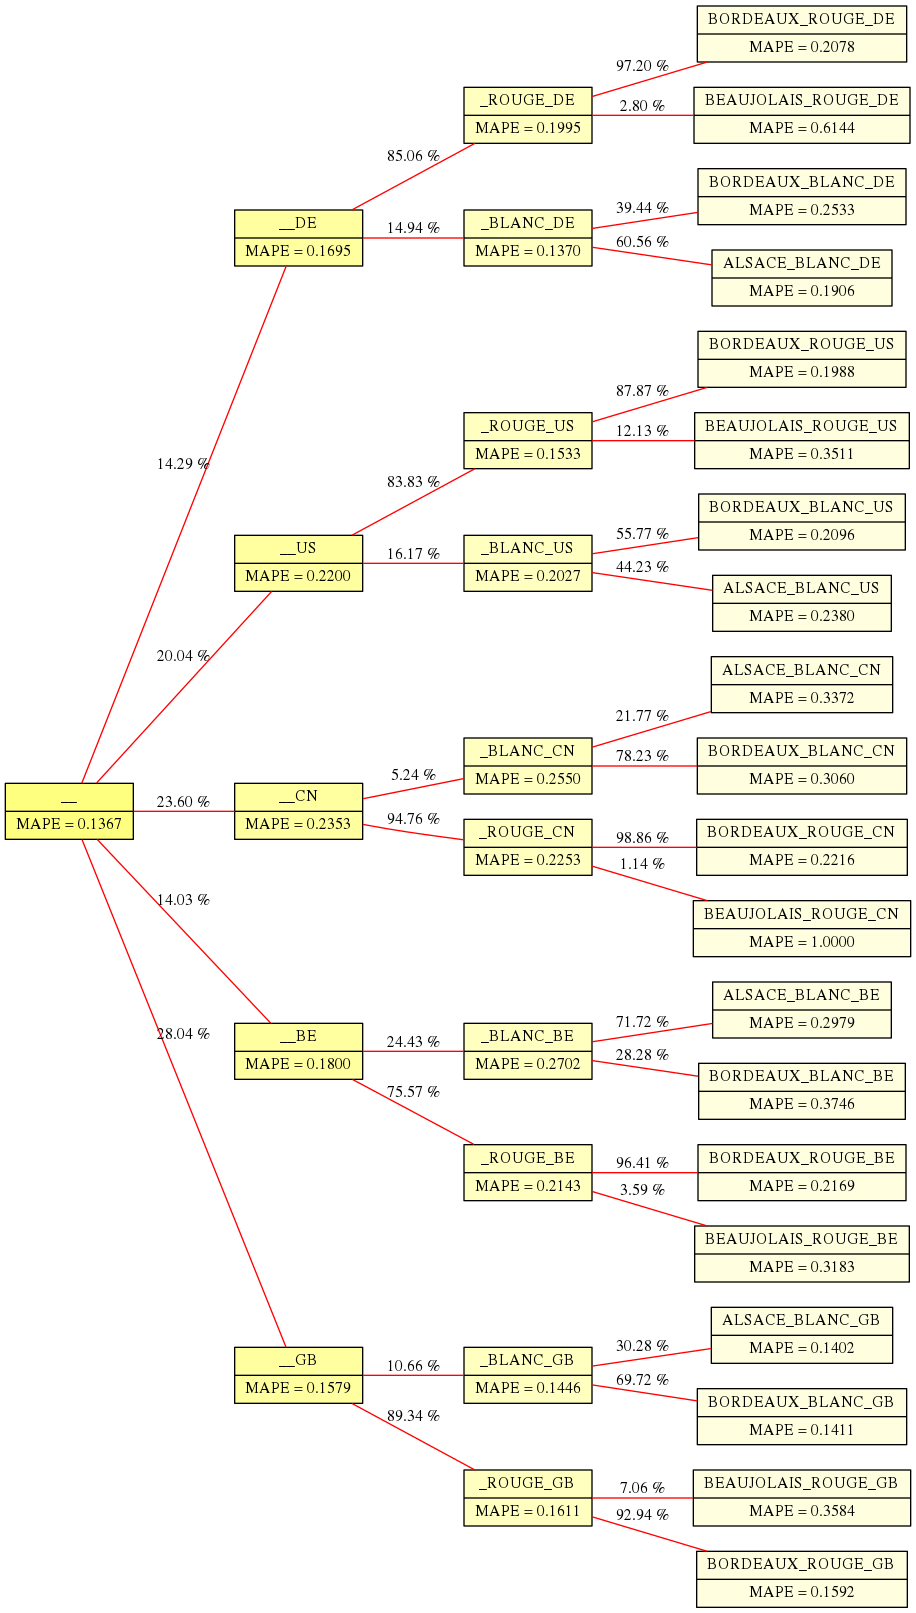

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.2552652359008789


In [26]:
lEngine.mSignalHierarchy.plot()

In [27]:
CN_Engine = lEngine.mSignalHierarchy.mModels[2]['__CN'] # __CN is at hierarchical level 2

In [28]:
CN_Engine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='Diff___CN' Min=-7241263.5 Max=8724178.0  Mean=57784.1956522 StdDev=3063515.42268
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE 'Diff_'
INFO:pyaf.std:BEST_DECOMPOSITION  'Diff___CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [ConstantTrend + NoCycle + AR(11)]
INFO:pyaf.std:TREND_DETAIL 'Diff___CN_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL 'Diff___CN_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL 'Diff___CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [AR(11)]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.3787 MAPE_Forecast=0.2353 MAPE_Test=0.0926
INFO:pyaf.std:MODEL_MASE MASE_Fit=2.1716 MASE_Forecast=0.7336 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=5843680.67377 L1_Forecast=2852608.78104 L1_Test=1104571.087

INFO:pyaf.std:START_PLOTTING
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
INFO:pyaf.std:END_PLOTTING_TIME_IN_SECONDS 1.0596323013305664


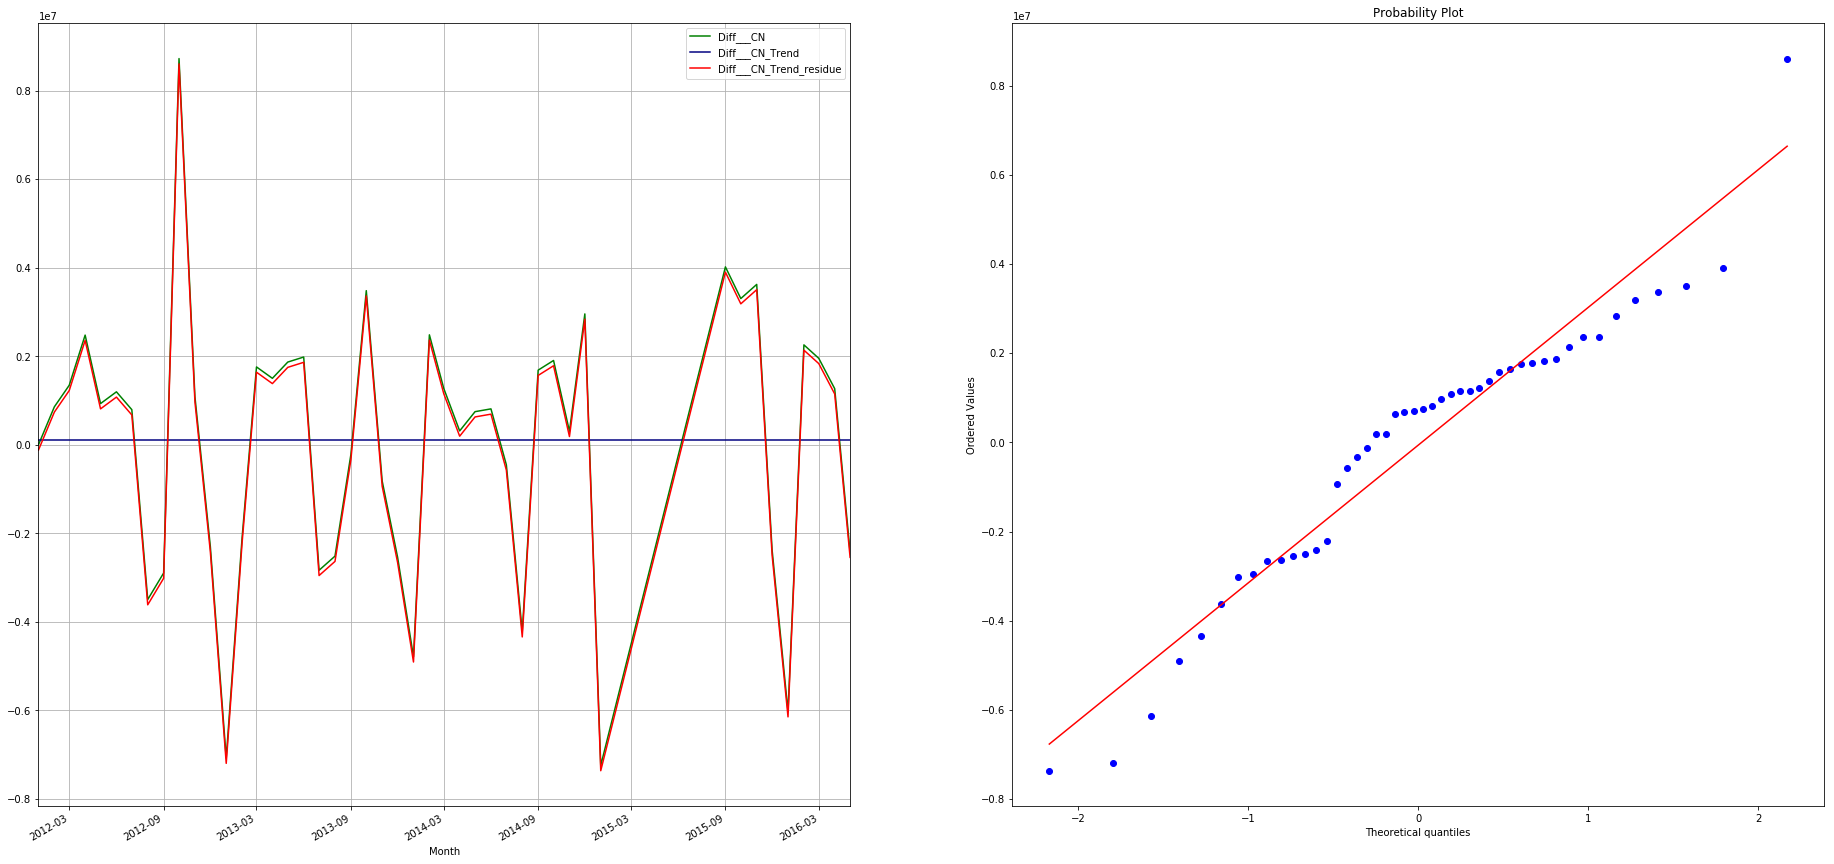

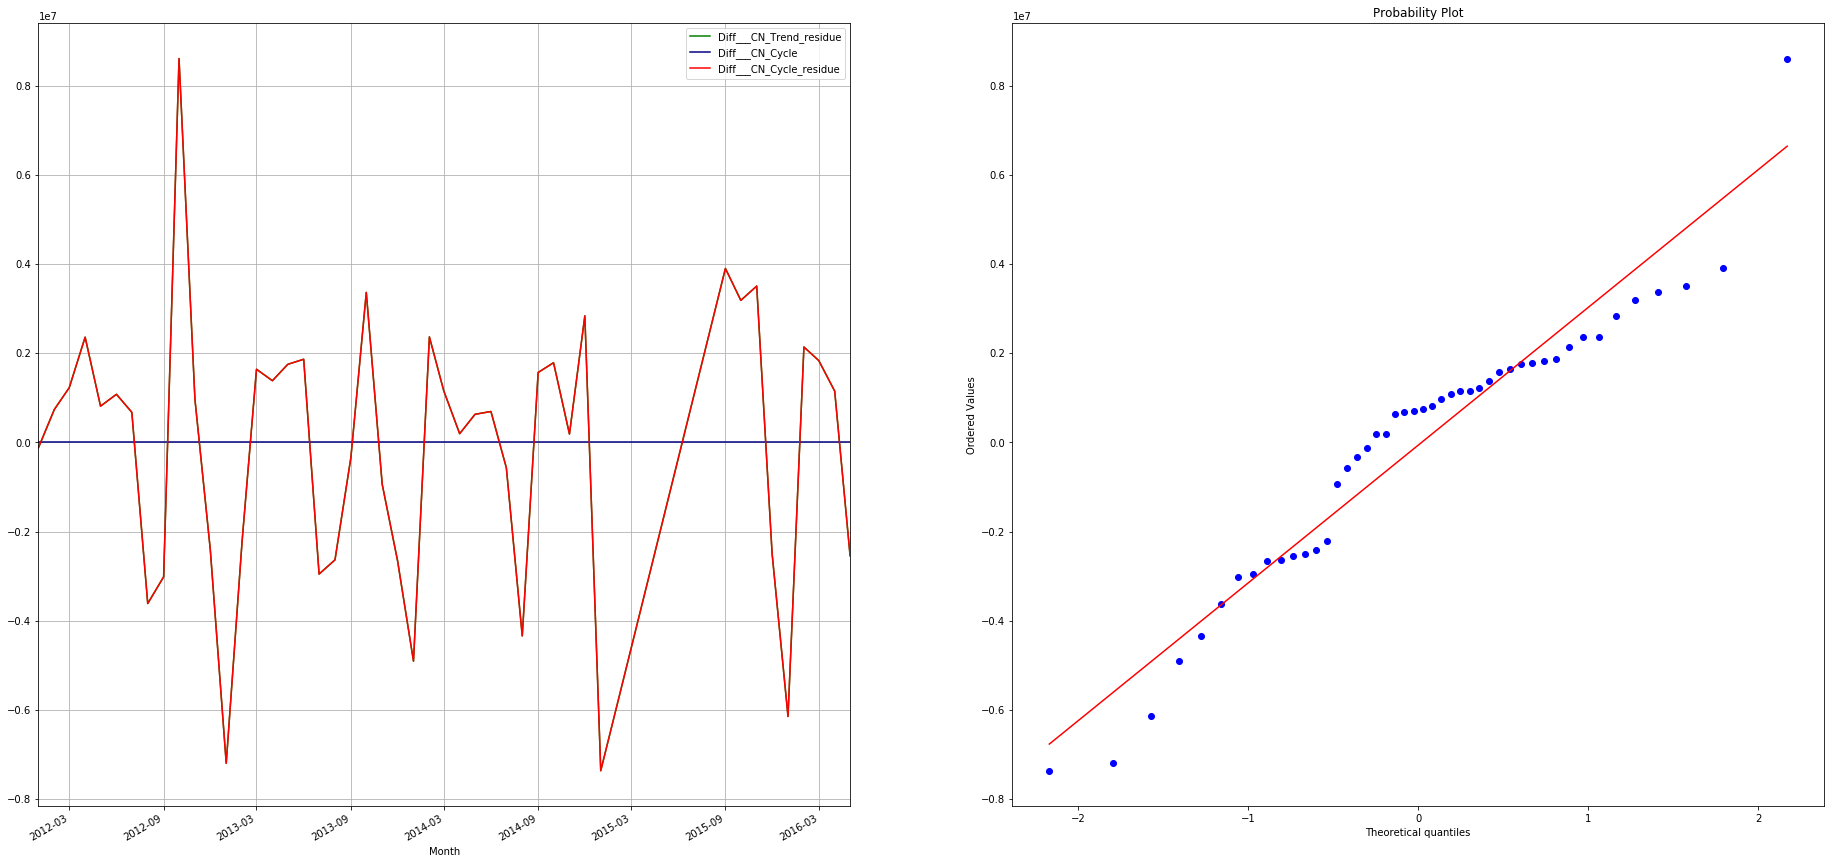

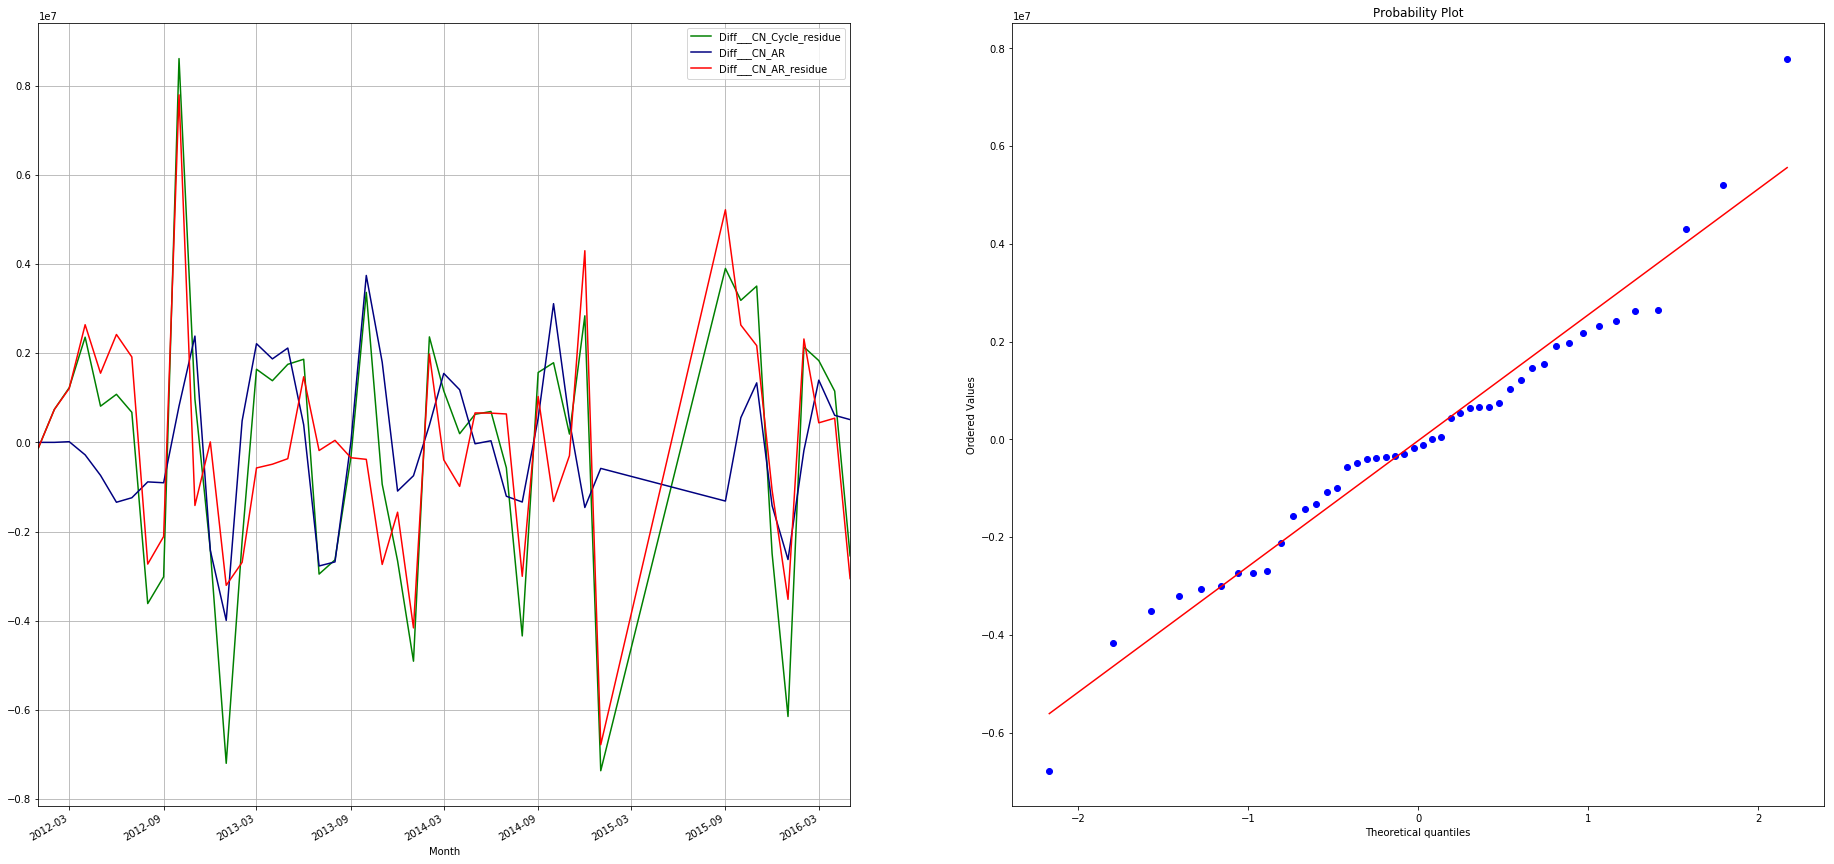

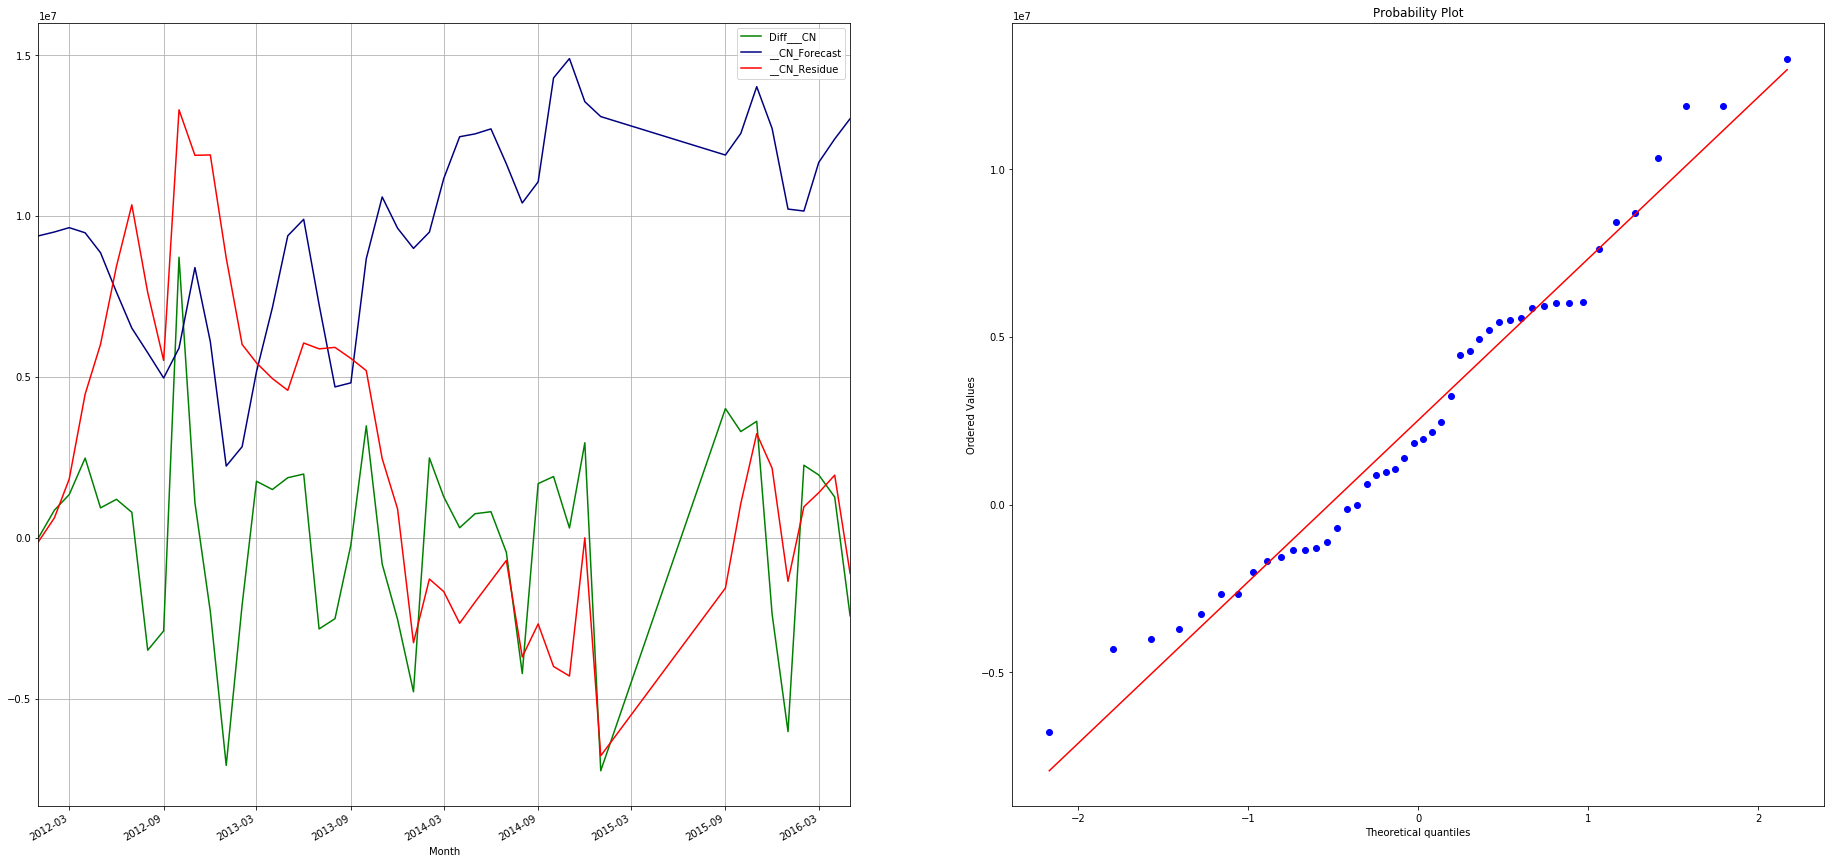

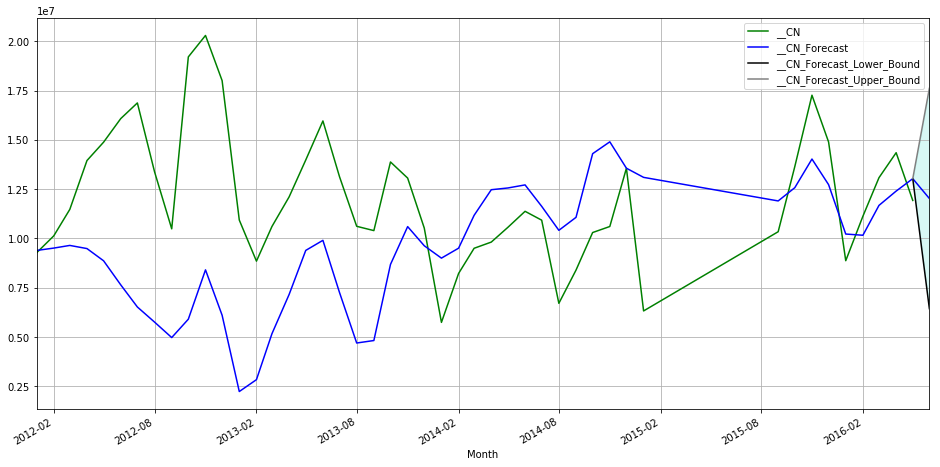

In [29]:
CN_Engine.standrdPlots()

## Hierarchical Forecast Combinations


### Bottom-Up / Top-Down and Middle-Out Forecasts

In [30]:
lEngine.mOptions.mHierarchicalCombinationMethod = ["BU" , 'TD' , 'MO' , 'OC'];
dfapp_out = lEngine.forecast(train_df, H);


INFO:pyaf.std:START_HIERARCHICAL_FORECASTING
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.06248188018798828
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.10973310470581055
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.0735023021697998
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.0640408992767334
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.08568787574768066
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.07135796546936035
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.06422209739685059
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.06394195556640625
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.06376910209655762
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.06999897956848145
INFO:py

STRUCTURE  [0, 1, 2, 3]
DATASET_COLUMNS Index(['Month', 'ALSACE_BLANC_BE', 'ALSACE_BLANC_BE_Forecast',
       'ALSACE_BLANC_CN', 'ALSACE_BLANC_CN_Forecast', 'ALSACE_BLANC_DE',
       'ALSACE_BLANC_DE_Forecast', 'ALSACE_BLANC_GB',
       'ALSACE_BLANC_GB_Forecast', 'ALSACE_BLANC_US',
       ...
       '_ROUGE_CN_OC_Forecast', '_ROUGE_DE_OC_Forecast',
       '_ROUGE_GB_OC_Forecast', '_ROUGE_US_OC_Forecast', '__BE_OC_Forecast',
       '__CN_OC_Forecast', '__DE_OC_Forecast', '__GB_OC_Forecast',
       '__US_OC_Forecast', '___OC_Forecast'],
      dtype='object', length=253)
STRUCTURE_LEVEL 

INFO:pyaf.std:END_HIERARCHICAL_FORECAST_TIME_IN_SECONDS 3.4878907203674316


 0 ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US']
MODEL_LEVEL  0 ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US']
STRUCTURE_LEVEL  1 ['_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_R

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


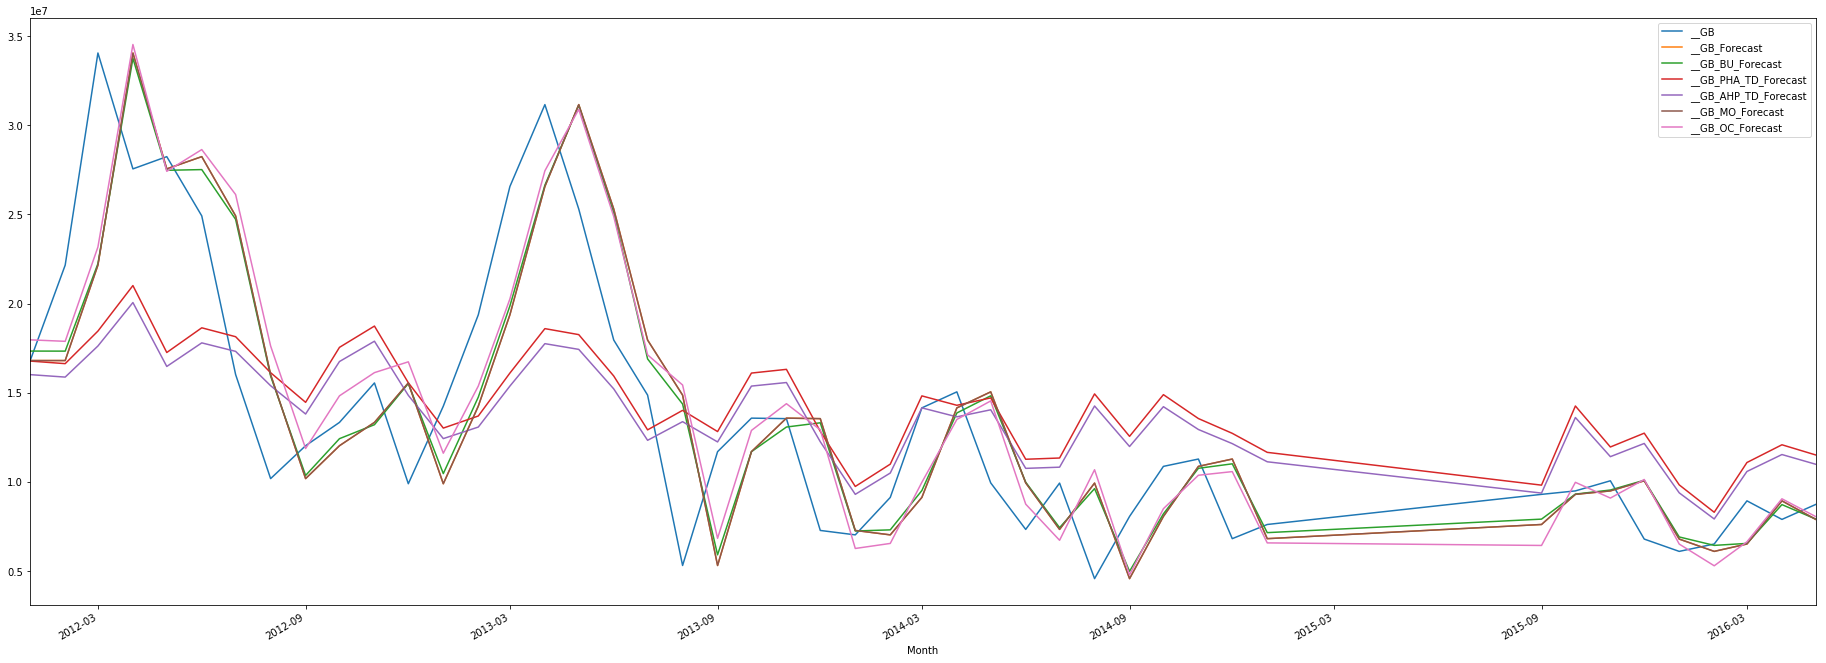

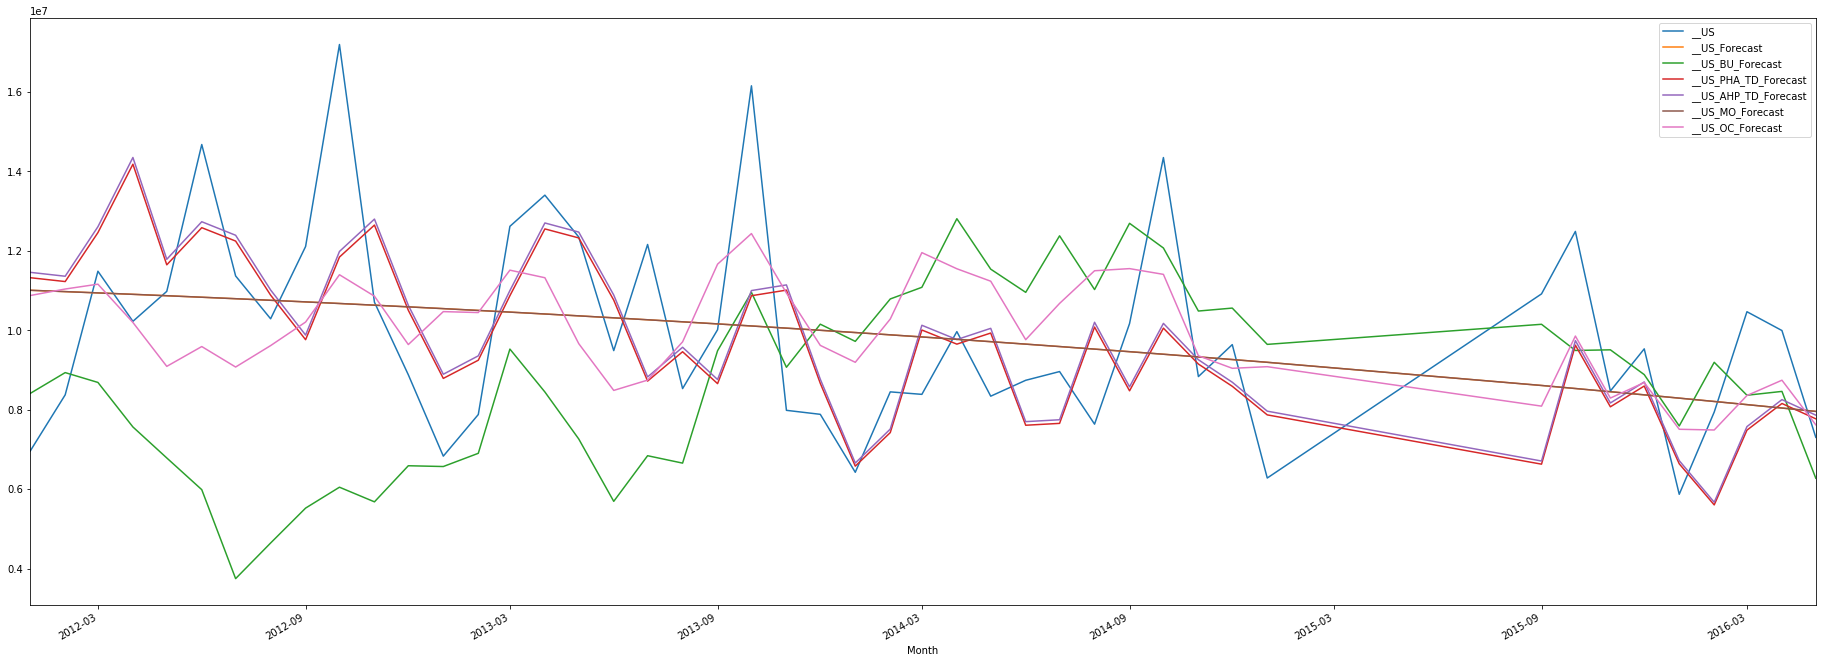

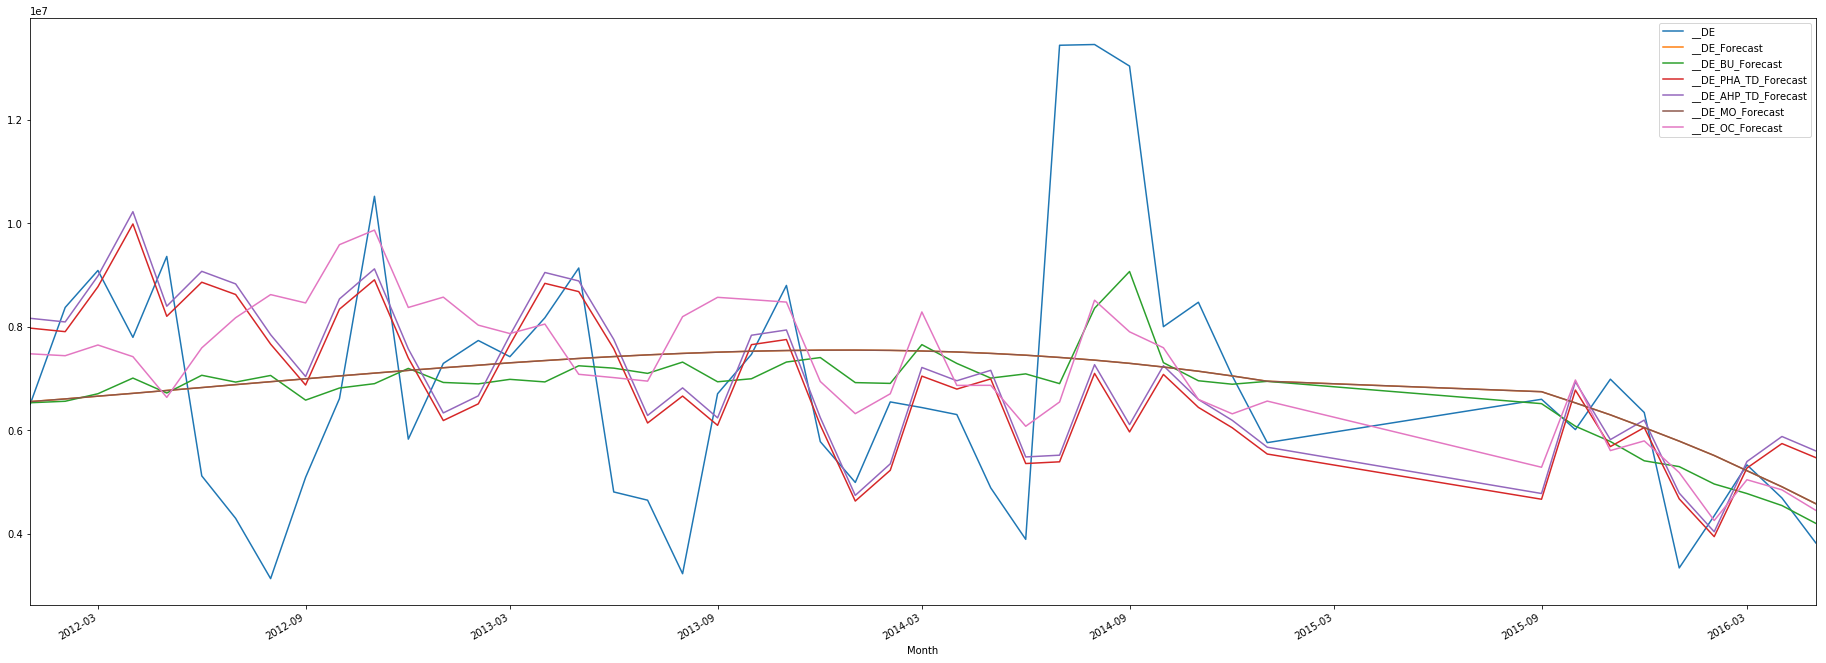

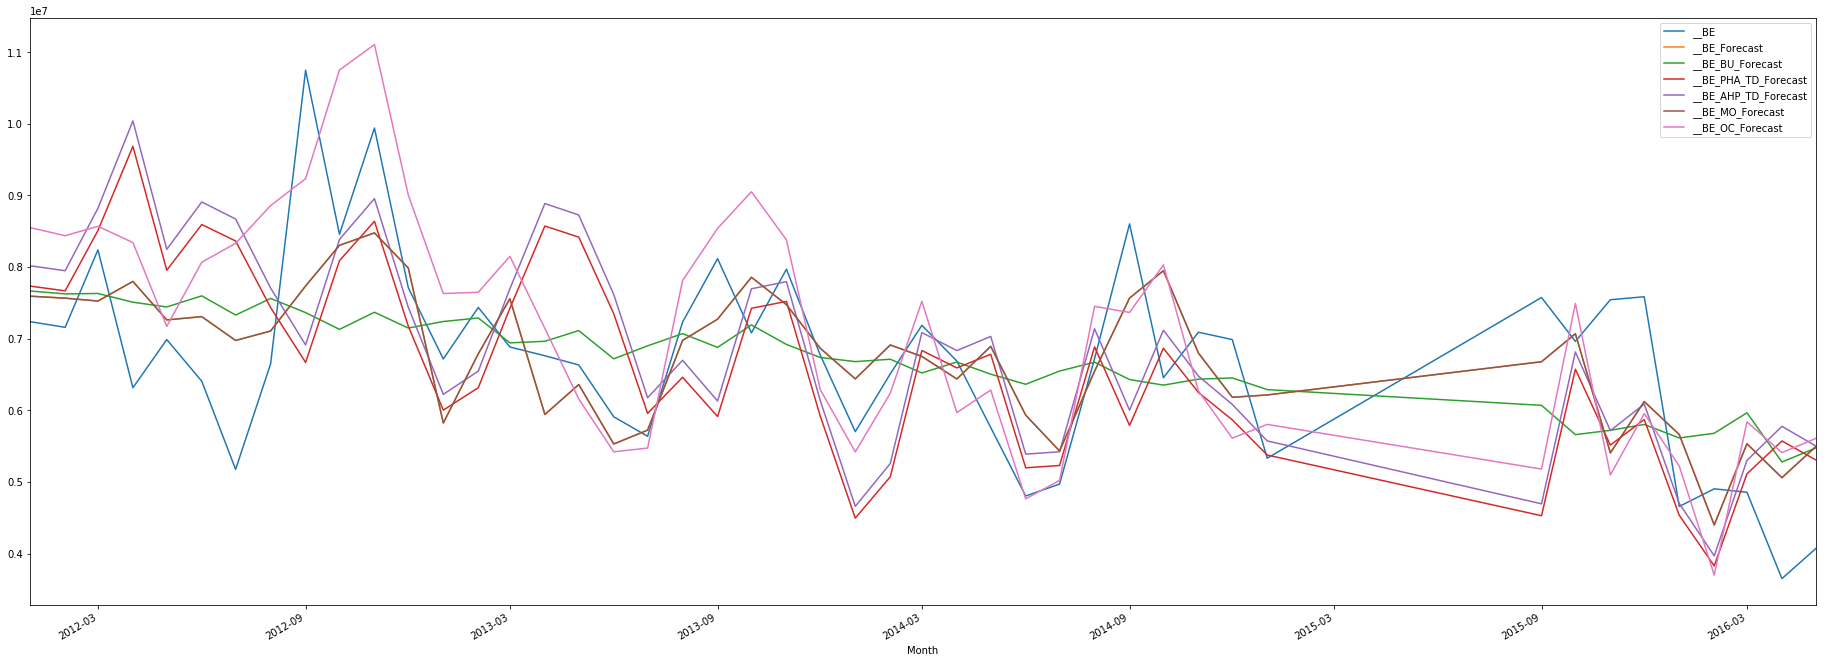

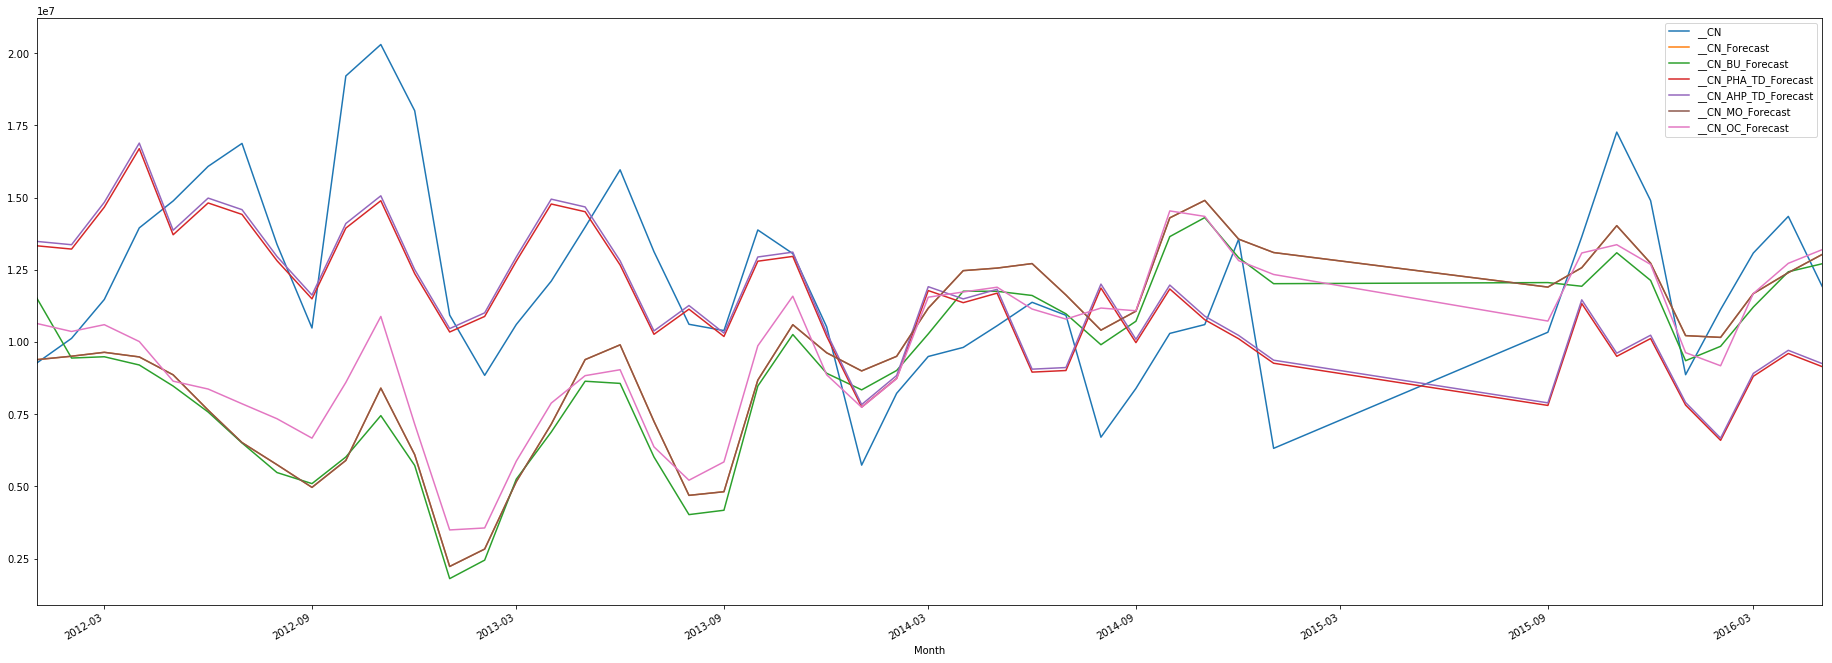

In [31]:
for c in Countries:
    country = "__" + c
    dfapp_out.plot('Month' , 
                    [country , country + '_Forecast' , 
                     country + '_BU_Forecast',  
                     country + '_PHA_TD_Forecast',  
                     country + '_AHP_TD_Forecast'  ,  
                     country + '_MO_Forecast' ,
                     country + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


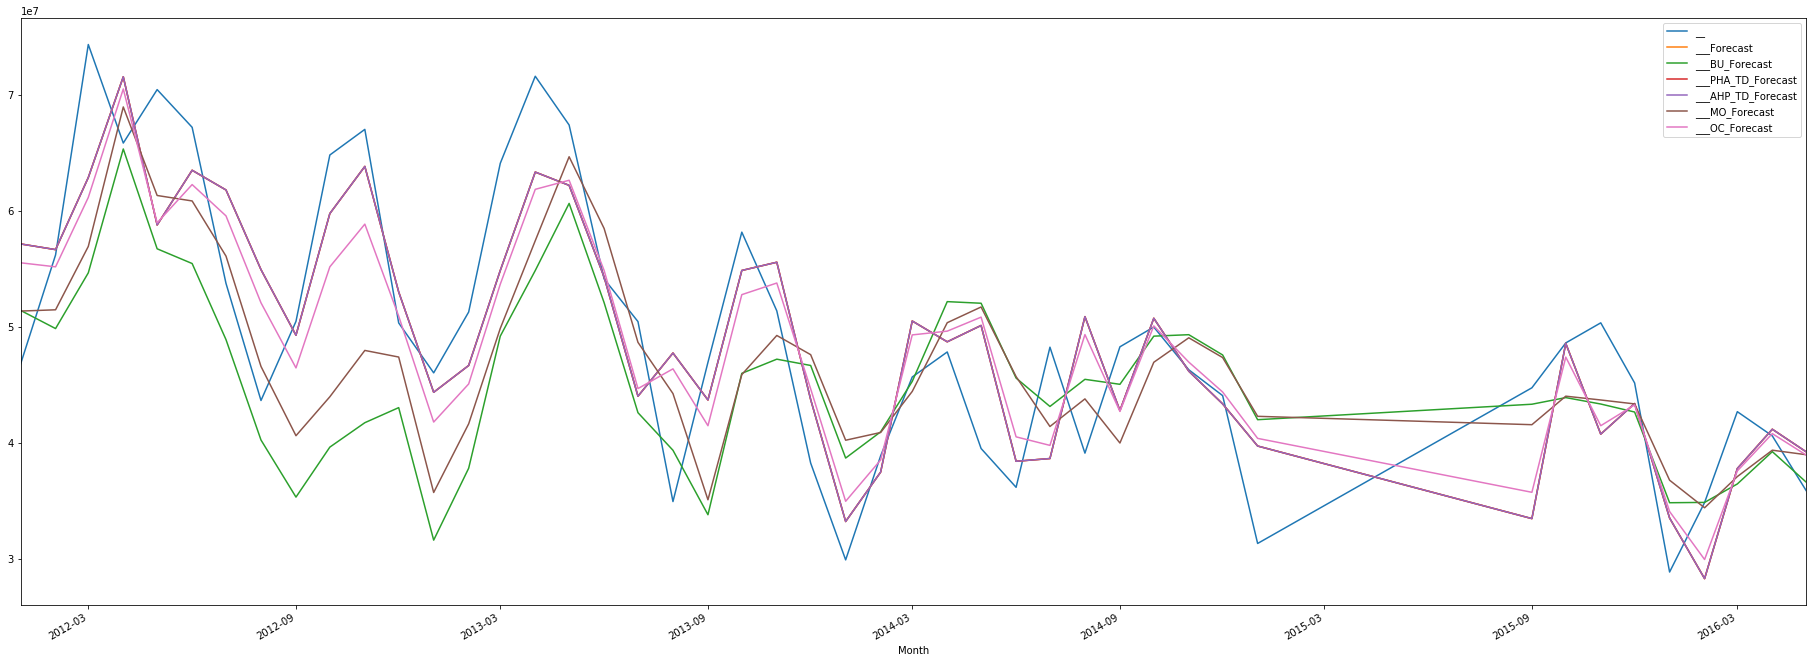

In [32]:
world = '__'
dfapp_out.plot('Month' , 
                [world , world + '_Forecast' , 
                 world + '_BU_Forecast',  
                 world + '_PHA_TD_Forecast',  
                 world + '_AHP_TD_Forecast'  ,  
                 world + '_MO_Forecast' ,
                 world + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)